In [18]:
#def FTS(xa,xb,ya,yb,xc,yckT,nframes,nstep,n_strings,mode,h):   
def FTS(xa,ya,xb,yb,xc,yc,kT,nframes,nstep,n_strings,mode,h,path):   
    '''Args
    FTS(nframes,nstep,n_strings,first_mode,last_mode,x,y,fes)
    nframes: Desired number of images in the string
    nstep: Number of Brownian dynamics steps to take on the surface
    n_strings: Number of strings to simulate
    mode: Mode number of interest
    x: Abcissa of the initial string
    y: Ordinate of the initial string
    fes: Free-energy surface on which to evolve the string'''
    
    #Pack ZTS and FTS into a single function -- problem with passing images that cross PBCs
    #when they are defined as separate functions
    #ZTS
    
    plt.close()
    
    #Do a little ZTS to get a good starting configuration
    bins=50
    xx,yy=np.meshgrid(np.linspace(0,180,bins),np.linspace(0,360,bins))

    nfrs=1

    barlist=[]
    pointslist=[]
    data = np.load(path+'anly_'+str(mode)+'.npy')[:,0:2]
    nfrs = len(data)
    print(nfrs)
    data=[data]
    ext1=[data[0][:,0].min(),data[0][:,0].max(),data[0][:,1].min(),data[0][:,1].max()]
    #model = mm.MSM(data)
    #his0 = model.histogram(0, bins=50)
    #his1 = model.histogram(1, bins=50)
    #his = model.histogram(bins=50)
    #ext=model.extent
    #lst=np.zeros(bins*bins)
    #chk=his.T/his.sum()
    #counter=-1
    #for i in range(len(chk[0,:])):
    #    for j in range(len(chk[:,0])):
    #        counter=counter+1
    #        lst[counter]=chk[i][j]
    #counter=0
    #fes=np.zeros((bins,bins))
    #for i in range(len(chk[0,:])):
    #    for j in range(len(chk[:,0])):
    #        if (lst[counter] <= 0):
    #            fes[i][j]=-np.log(1/nfrs)
    #            counter=counter+1
    #        else:
    #            fes[i][j]=-np.log(lst[counter])
    #            counter=counter+1
    fes = np.load(path+'fes'+str(mode)+'.npy')
    fes = fes -fes.min()
    theta=np.linspace(0,180,bins)
    phi=np.linspace(0,360,bins)
    
    #Smooth the surface with k-nearest neighbors
    n_values = 100
    alpha = 2

    x0, x1 = np.meshgrid(theta,phi)
    X = np.column_stack([x0.ravel(), x1.ravel()])
    score = []
    for n_neighbor in np.arange(alpha, n_values * alpha + 1, alpha):
        for train_index, test_index in ShuffleSplit(n_splits=1, test_size=0.40, random_state=24).split(X):
            X_train, y_train = X[train_index], fes.ravel()[train_index]
            X_test, y_test = X[test_index], fes.ravel()[test_index]

        knn = KNeighborsRegressor(n_neighbors=n_neighbor).fit(X_train, y_train)
        score.append(mean_squared_error(knn.predict(X_test), y_test))
    if np.argmin(score) == 0:
        n_neighbors=2
        print("Hmm... no nearest neighbors. Setting k:=1.")
    else:
        n_neighbors = np.argmin(score) * alpha
    print("k = {:d}".format(np.argmin(score)))
    knn = KNeighborsRegressor(n_neighbors=n_neighbors).fit(X, fes.ravel())
    fes_knn = knn.predict(X).reshape(bins, bins)
    #fes_knn=fes
    dVy,dVx=np.gradient(fes_knn,360/bins,180/bins)
    dVx=interpolate.interp2d(theta,phi,dVx,kind='quintic')
    dVy=interpolate.interp2d(theta,phi,dVy,kind='quintic')
    ifes=interpolate.interp2d(theta,phi,fes_knn,kind='quintic')
    
    #Now convert the code from the ZTS Matlab code
    tol1=0.00001 #Convergence criterion
    tollist=[]
    flag1=1
    nstepplot=100

    g1=np.linspace(0,1,nframes)
    #Perform the interpolation; same as above
    
    if xa == xb:
        xb=xa+np.random.randn()
    if ya == yb:
        yb=ya+np.random.randn()
    print(xa,ya)
    print(xb,yb)
 
    #Use an intermediate point to go around barriers
    nfrs1=nframes//2
    nfrs2=nframes-nfrs1
    
    g1=np.linspace(0,1,nfrs1)
    g1=np.append(g1,np.zeros(nfrs1))
    
    g2=np.linspace(0,1,nfrs2)
    g2=np.append(np.zeros(nfrs2),g2)
    x=(xb-xa)*g1+(xc-xb)*g2+xa
    y=(x-xa)*(yc-ya)/(xc-xa)+ya
    
    x=(xb-xa)*g1+(xa*np.append(np.ones(nfrs1),np.zeros(nfrs1)))
    #print(x)
    y=(np.copy(x)-(xa*np.append(np.ones(nfrs1),np.zeros(nfrs1))))*(yb-ya)/(xb-xa)+(ya*np.append(np.ones(nfrs1),np.zeros(nfrs1)))
    #print(y)
    x +=(xc-xb)*g2+(xb*np.append(np.zeros(nfrs2),np.ones(nfrs2)))
    #print(x)
    y +=(np.copy(x)-xb)*np.append(np.zeros(nfrs2),np.ones(nfrs2))*(yc-yb)/(xc-xb)+(yb*np.append(np.zeros(nfrs2),np.ones(nfrs2)))
  
    g1=np.linspace(0,1,nframes)
    #x=(xb-xa)*g1+xa
    #y=(x-xa)*(yb-ya)/(xb-xa)+ya
    #y=(x-xa)*(yb-ya)/(xb-xa)-0.1*(x-xa)*(xb-x)+ya
    #y=np.sqrt(x)
    dx=x-np.roll(x,1,axis=0)
    dy=y-np.roll(y,1,axis=0)
    dx[0]=0
    dy[0]=0
    lxy=np.cumsum(np.sqrt(dx**2+dy**2))
    lxy=lxy/lxy[nframes-1]
    
    #Honestly not sure why these two lines are here; the x, y that are returned
    #are identical to the x, y generated by the linear interpolation.
    x=interpolate.interp1d(lxy,x)(g1)
    y=interpolate.interp1d(lxy,y)(g1)
    xi=np.copy(x)
    yi=np.copy(y)

    counter=1

    laplist=[]
    grady,gradx=np.gradient(fes_knn,360/bins,180/bins)
    lapxy,lapxx=np.gradient(gradx)
    lapyy,lapyx=np.gradient(grady)
    #h=1/(np.array([lapxx.max(),lapxy.max(),lapyx.max(),lapyy.max()]).max())
    #h=0.1#Just a parameter -- proabably need to adjust to get good convergence
    print('h=',h)
    print(nstep)

    dVy,dVx=np.gradient(fes_knn,360/bins,180/bins)
    dVx=interpolate.interp2d(theta,phi,dVx,kind='quintic')
    dVy=interpolate.interp2d(theta,phi,dVy,kind='quintic')
    dVy2,dVx2=np.gradient(fes_knn,360/bins,180/bins)
    dVx2=interpolate.interp2d(theta,phi+360.0,dVx2,kind='cubic')
    dVy2=interpolate.interp2d(theta,phi+360.0,dVy2,kind='cubic')
    dVy3,dVx3=np.gradient(fes_knn,360/bins,180/bins)
    dVx3=interpolate.interp2d(theta,phi-360.0,dVx3,kind='cubic')
    dVy3=interpolate.interp2d(theta,phi-360.0,dVy3,kind='cubic')
    for i in range(nstep):

        x0=np.copy(x)
        y0=np.copy(y)
        # Evolve the string using steepest descent
        for j in range(len(x)):
            here=False
            if y[j] <=0.0: 
                #y[j] = 0.0
                here=True
                deltax=-h*dVx3(x[j],y[j])[0]
                deltay=-h*dVy3(x[j],y[j])[0]
                x[j]=x[j]+deltax
                y[j]=y[j]+deltay
                #if i % 100 == 0:
                #    print(deltax,deltay)

            if y[j] >=360.0:
                here=True
                #y[j] = 360.0
                deltax=-h*dVx2(x[j],y[j])[0]
                deltay=-h*dVy2(x[j],y[j])[0]
                x[j]=x[j]+deltax
                y[j]=y[j]+deltay
                #if i % 100 == 0:
                #    print(deltax,deltay)
                    
            if x[j] <=0.0:
                x[j] = 0.0
                here=True
                #x[j]=x[j]-h*dVx(x[j],y[j])[0]
                deltay=-h*dVy(x[j],y[j])[0]
                y[j]=y[j]+deltay

            if x[j] >= 180.0:
                x[j]=180.
                here=True
                #x[j]=x[j]-h*dVx(x[j],y[j])[0]
                deltay=-h*dVy(x[j],y[j])[0]
                y[j]=y[j]+deltay

            elif not here:
                if here:
                    print('I came here, too!')
                deltax=-h*dVx(x[j],y[j])[0]
                deltay=-h*dVy(x[j],y[j])[0]
                x[j]=x[j]+deltax
                y[j]=y[j]+deltay
            #Enforce PBCs
            #KLUDGE: Not letting them cross for now
        #Reparameterize
        dx=np.copy(x)-np.roll(x,1,axis=0)
        dy=np.copy(y)-np.roll(y,1,axis=0)
        dx[0]=0
        dy[0]=0
        #Find the string length...
        lxy=np.cumsum(np.sqrt(dx**2+dy**2))
        lxy=lxy/lxy[nframes-1]
        #...and place each state at an equally-spaced length along the string
        x=interpolate.interp1d(lxy,x)(g1)
        y=interpolate.interp1d(lxy,y)(g1)
        tol=(np.linalg.norm(x-x0)+np.linalg.norm(y-y0))/(nframes)
        tollist.append(tol)
        #if len(tollist) >=3:
        #    if tollist[i-3]-tollist[i] == 0:
        #        print('converged')
        #        break
        if tol <= tol1: #Has the string converged?
            pass#break #It has converged!
        if i%nstepplot == 0:
            #summa=0.0
            #for n in range(len(x)):
            #    summa += ifes(x[n],y[n])[0]
            #print('Total Energy: ',summa)
            print(tol)
    print('\n')
    print('\n')
    print('ZTS calculation with ',nframes,' images.\n')

    plt.contourf(xx,yy,fes,cmap='Spectral')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    xplot=np.copy(x)
    yplot=np.copy(y)
    #for i in range(len(yplot)):
    #    if yplot[i] <= 0.0:
    #        yplot[i]=yplot[i]+360.0
    #    if yplot[i] >= 360.0:
    #        yplot[i]=yplot[i]-360.0
    plt.scatter(xplot,yplot,marker='o',c='w')
    #plt.plot(x,y,'b')
    plt.xlim((0,180))
    plt.ylim((0,360))
    #plt.savefig(savepath+'ZTS-final-'+str(mode)+'.pdf')
    plt.show()
    plt.close()
    ifes=interpolate.interp2d(theta,phi,fes,kind='quintic')
    points=[]
    for i in range(len(x)):
        points.append(ifes(x[i],y[i])[0])
        #print(points[i])
    pointslist.append(points)
    #np.savetxt("ZTS-points"+str(mode),points)
    #np.savetxt("coords_"+str(mode)+".dat",np.column_stack([x,y]))
    #plt.plot(points,'k')
    #plt.xlabel('Image Number')
    #plt.ylabel('free energy ($k_BT$)')
    bar=np.max(np.array(points))-np.min(np.array(points))
    print(r'Barrier Height ($k_BT$): ',bar)
    barlist.append(bar)
    np.savetxt('barrier'+str(mode)+'_'+str(orient),np.array(bar).reshape(1,))
    #np.savetxt(savepath+"ZTS-barlist.dat",np.array(barlist))
    #np.savetxt(savepath+"ZTS-coords_"+str(mode)+".dat",np.column_stack([x,y]))
    plt.contourf(xx,yy,fes,cmap='Spectral')
    plt.xlabel(r'$\theta\ (deg)$')
    plt.ylabel(r'$\phi\ (deg)$')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    plt.show()
    plt.close()
    
    nbins = 100
    fes1 = fes
    ext = ext1
    xplot = np.copy(x)#[::5]
    #xplot = np.insert(xplot,0,x[0])
    #xplot = np.insert(xplot,-1,x[-1])
    yplot = np.copy(y)#[::5]
    #yplot = np.insert(yplot,0,y[0])
    #yplot = np.insert(yplot,-1,y[-1])
    
    #xplot = xplot[::5]
    #yplot = yplot[::5]
    colors = plt.cm.seismic(np.linspace(0,1,len(xplot)))
    plt.contourf(fes1,zorder=-13,levels=np.linspace(fes1.min(),fes1.max(),nbins//4),cmap='gnuplot',extent=ext1)
    plt.contour(fes1,zorder=-12,levels=np.linspace(fes1.min(),fes1.max(),nbins//4),colors='k',extent=ext1)
    for i in range(len(xplot)):
        if yplot[i] >= 360: yplot[i] -= 360
        if yplot[i] <= 0: yplot[i] += 360
    #plt.plot(xplot,yplot,color='k',lw=2,ls='--')
    for i in range(len(xplot)):
        plt.plot(xplot[i],yplot[i],color=colors[i],marker='o',markeredgecolor='k')#,markersize=10)
    
    
    plt.xlabel(r'$\theta\ (deg)$',fontsize=20)
    plt.ylabel(r'$\phi$ (deg)',fontsize=20)

    plt.xlim((ext[0],ext[1]))
    plt.ylim((ext[2],ext[3]))
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.tight_layout()
    plt.savefig(path+'ZTS-final-'+str(mode)+str(orient)+'.eps',dpi=300)
    plt.show()
    plt.close()


    return x,y,fes1,fes_knn

In [15]:
import numpy as np
import matplotlib.pyplot as plt
#import Markov_Models as mm
from scipy import stats
from scipy import interpolate
from scipy import spatial
from scipy import integrate
import os
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error
import subprocess

path='../'
savepath=path

print(os.getcwd())

/media/ebeyerle/ducks2/1mus/0.2ps_step/PCA/notebooks


[100.  112.5 125.  137.5 150.  150.  140.  130.  120.  110. ]
[ 10.    32.5   55.    77.5  100.   100.   123.75 147.5  171.25 195.  ]


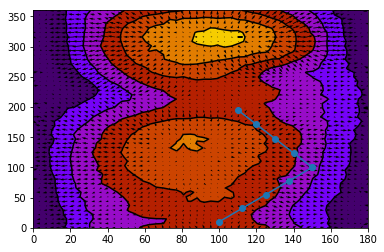

In [33]:
%matplotlib inline
path='../'
savepath=path
bins=50
mode=1
theta=np.linspace(0,180,50)
phi=np.linspace(0,360,50)
xx,yy=np.meshgrid(np.linspace(0,180,50),np.linspace(0,360,50))
for mode in [10]:
    nfrs=0
    #with open(path+'theta_phi_'+str(mode)+'.dat','r') as data:
    #    x=[]
    #    y=[]
    #    for line in data:
    #        nfrs=nfrs+1
    #        p=line.split()
    #        x.append(float(p[0]))
    #        y.append(float(p[1]))
    #print(nfrs)
    #data=[np.column_stack([x,y])]

    fes = np.load(path+'fes'+str(mode)+'.npy')

    plt.contour(xx,yy,fes,colors='k')
    plt.contourf(xx,yy,fes,cmap=plt.cm.gnuplot,extent=(0,180,0,360))
    dVy,dVx=np.gradient(fes,360/bins,180/bins)
    dVx=interpolate.interp2d(theta,phi,dVx,kind='linear')
    dVy=interpolate.interp2d(theta,phi,dVy,kind='linear')
    plt.quiver(xx,yy,-dVx(theta,phi),-dVy(theta,phi))
    
    nframes=10
    xa=100
    ya=10
    
    xb=150
    yb=100
    
    xc=110
    yc=195
    g1=np.linspace(0,1,nframes//2)
    g1=np.append(g1,np.zeros(5))
    
    g2=np.linspace(0,1,nframes//2)
    g2=np.append(np.zeros(5),g2)
    x=(xb-xa)*g1+(xc-xb)*g2+xa
    y=(x-xa)*(yc-ya)/(xc-xa)+ya
    
    x=(xb-xa)*g1+(xa*np.append(np.ones(5),np.zeros(5)))
    #print(x)
    y=(np.copy(x)-(xa*np.append(np.ones(5),np.zeros(5))))*(yb-ya)/(xb-xa)+(ya*np.append(np.ones(5),np.zeros(5)))
    #print(y)
    x +=(xc-xb)*g2+(xb*np.append(np.zeros(5),np.ones(5)))
    #print(x)
    y +=(np.copy(x)-xb)*np.append(np.zeros(5),np.ones(5))*(yc-yb)/(xc-xb)+(yb*np.append(np.zeros(5),np.ones(5)))
    #print(y)
    #y=(x-xa)*(yb-ya)/(xb-xa)-0.1*(x-xa)*(xb-x)+ya
    print(x)
    print(y)
    plt.plot(x,y,marker='o')
    plt.show()
    plt.close()
    None

5.0 0.5
5000000
k = 2
10 230
100 210
h= 5.0
2000
0.049568673077198255
0.013804273908228009
0.012970070547761937
0.015079994369486417
0.008593107598759302
0.006232095931060716
0.00442704223166874
0.004399018170402398
0.005314925825610051
0.003995809307096813
0.00358705079750808
0.0034968620949739483
0.0023995815584536497
0.0026672606806443537
0.002679549567222027
0.003148936460016811
0.0032364202042985445
0.003256484319767617
0.003324878360228975
0.0034128646846017653




ZTS calculation with  50  images.



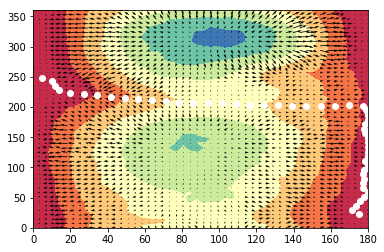

Barrier Height ($k_BT$):  1.2762131218691928


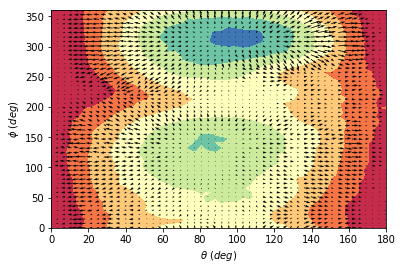

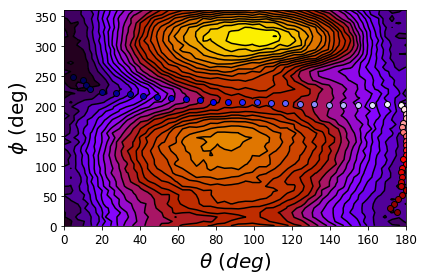

CPU times: user 16.6 s, sys: 289 ms, total: 16.9 s
Wall time: 10.8 s


In [39]:
%%time
#Now, I'm going to press my luck and run in it for more modes Run it for all the modes
%matplotlib inline
bins=50
kT=0.5
xx,yy=np.meshgrid(np.linspace(0,180,bins),np.linspace(0,360,bins))
orient='top'

for h in [5.0]:
    print(h,kT)
    for i in [10]:
        #x,y,fes=ZTS(50,1000,i,i+1)  
        x,y,fes,fes_knn=FTS(10,230,100,210,170,25,0.5,50,2000,1,i,h,path) #Low precision 
        #x,y,xstrings,ystrings,fes=FTS(0.5,200,10,1000,i,i+1,x,y,fes) #High precision
        np.save(path+'x'+str(i)+'bottom.npy',x)
        np.save(path+'y'+str(i)+'bottom.npy',y)

In [38]:
for i in [10]:
    dummy = np.loadtxt('../anly_' + str(i) + '.dat')
    np.save('../anly_' + str(i) +'.npy', dummy)
    subprocess.call('rm -rfv ../anly_' + str(i) + '.dat', shell = True)